# Facial Detection and Recognition

#### Gregory Van

This project will aim to detect faces in an image using a Haar feature-based cascade classifier. For facial recognition, the Local Binary Patterns Histograms (LBPH) algorithm will be used as it is simple and easy to understand. I will try to correctly classify images of Andrew Ng, Simu Liu and myself. To trained the model, I found 12 images of each one of us and labeled them appropriately. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

In [2]:
# This funtion takes in an image and scales it to a width of 40px while preserving the aspect ratio
def scale_img(image):
    height = image.shape[0]
    width = image.shape[1]
    # Scale the width of new image to 200px and preserve aspect ratio
    new_width = 200 
    ratio = new_width / width 
    new_height = int(height * ratio)
    dimensions = (new_width, new_height)
    scaled_image = cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)
    return scaled_image

In [3]:
# This function will detect faces of images using the Haar cascade classifier. It will only return a max of one detected face.
def detect_face(image, cascade_path):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cascade_path)
    face = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5)
    if (len(face) == 0):
        return None, None
    x, y, w, h = face[0]
    # Return cropped image of only the face detected 
    return gray[y:y+w, x:x+h], face[0]

In [4]:
# This function reads in all the training data and returns the images as well as their labels (name of person in the image). Note that images are located in folders that are named after the labels.
def load_training_data(train_path, cascade_path):
    dirs = os.listdir(train_path)
    faces = []
    names = []
    for dir_name in dirs:
        # Each image has been put in the folder named after that person.
        name = str(dir_name)
        # Get list of file names for each image in the folder.
        individual_dir_path = train_path + "/" + dir_name
        images_names = os.listdir(individual_dir_path)
        # Go through the images and read them in.
        for image_name in images_names:
            image_path = individual_dir_path + "/" + image_name
            image = cv2.imread(image_path)

            # Detect a face in the image.
            face, rect = detect_face(image, cascade_path)

            # Will not include images where a face was not detected.
            if face is not None:
                faces.append(face)
                names.append(name)
                
    return faces, names

In [5]:
# Use the LBPH recognizer to create a facial recognition model based off of our training data.
def train(train_path, cascade_path):
    faces, names = load_training_data(train_path, cascade_path)
    
    # Scale all images of faces
    for face in faces:
        face = scale_img(face)
    
    # Get list of unique names.
    name_list = list(set(names))
    
    # Create a dictionary so we can map the names to a numerical value as LBPH requires int types.
    dict_names = {name: index for index, name in enumerate(name_list)}
    values = []
    for name in names:
        values.append(dict_names[name])
    face_recognizer = cv2.face.LBPHFaceRecognizer_create()
    face_recognizer.train(faces, np.array(values))
    return face_recognizer, name_list

In [6]:
# Use to predict images and draw rectangles around detected faces and label them with the prediction
def predict(img, name_list):
    # Detect face in image
    face, rect = detect_face(img, cascade_path)
    
    # Will make a copy of the image as we will draw boxes and labels on them
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # One of the outputs of face_recognizer.predict is the confidence. However, the higher the value, the less it is similiar. I will call it loss to avoid confusion.
    # Will set loss initially to N/A in case a face is not detected in the image.
    loss = 'N/A'
    
    if face is not None:
        # The prediction will return the label value and the confidence (we are calling it loss in this case).
        # Scale all image of face
        face = scale_img(face)
        prediction = face_recognizer.predict(face)
        loss = round(prediction[1], 2)
        
        # Map the value back to the name
        name = name_list[prediction[0]]

        # Draw a rectangle around the detected face
        (x, y, w, h) = rect
        cv2.rectangle(rgb_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Write the name of predicted person on the image
        cv2.putText(rgb_img, name, (x, y-5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

    return rgb_img, loss

In [7]:
# Load the test images and predict the person in the image.
def test(test_path):
    images = []
    truths = []
    losses = []
    
    # Get filenames of all test images
    image_names = os.listdir(test_path)
    for image_name in image_names:
        # All image filenames start with the ground truth name of the person in it. Splitting the name of the file to before any spaces will get the ground truth.
        truth = image_name.split()[0]
        truths.append(truth)
        image_path = test_path + "/" + image_name
        image = cv2.imread(image_path)
        predicted_img, loss = predict(image, name_list)
        images.append(predicted_img)
        losses.append(loss)
        
    return images, truths, losses

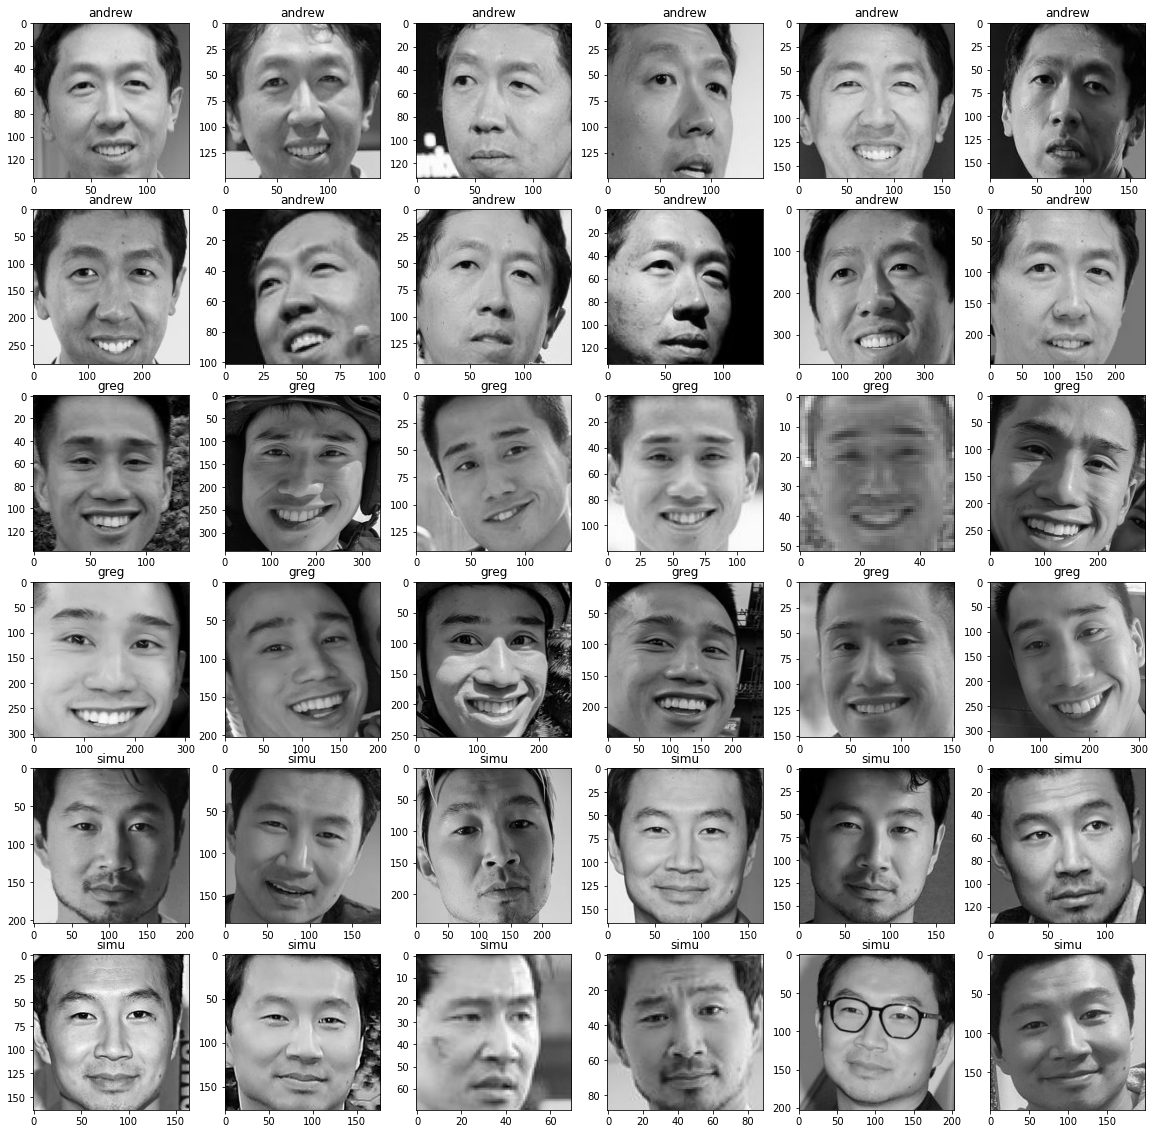

In [8]:
# Look at the training images
cascade_path = 'data/haarcascades/haarcascade_frontalface_alt.xml'
train_path = 'train'
faces, names = load_training_data(train_path, cascade_path)

fig = plt.figure(figsize=(20, 20))
columns = 6
rows = 6

for count, (face, name) in enumerate(zip(faces, names), start=1):
    rgb_img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, count)
    plt.title(name)
    plt.imshow(rgb_img)
plt.show()
    

In [9]:
# Train the model.
face_recognizer, name_list = train(train_path, cascade_path)

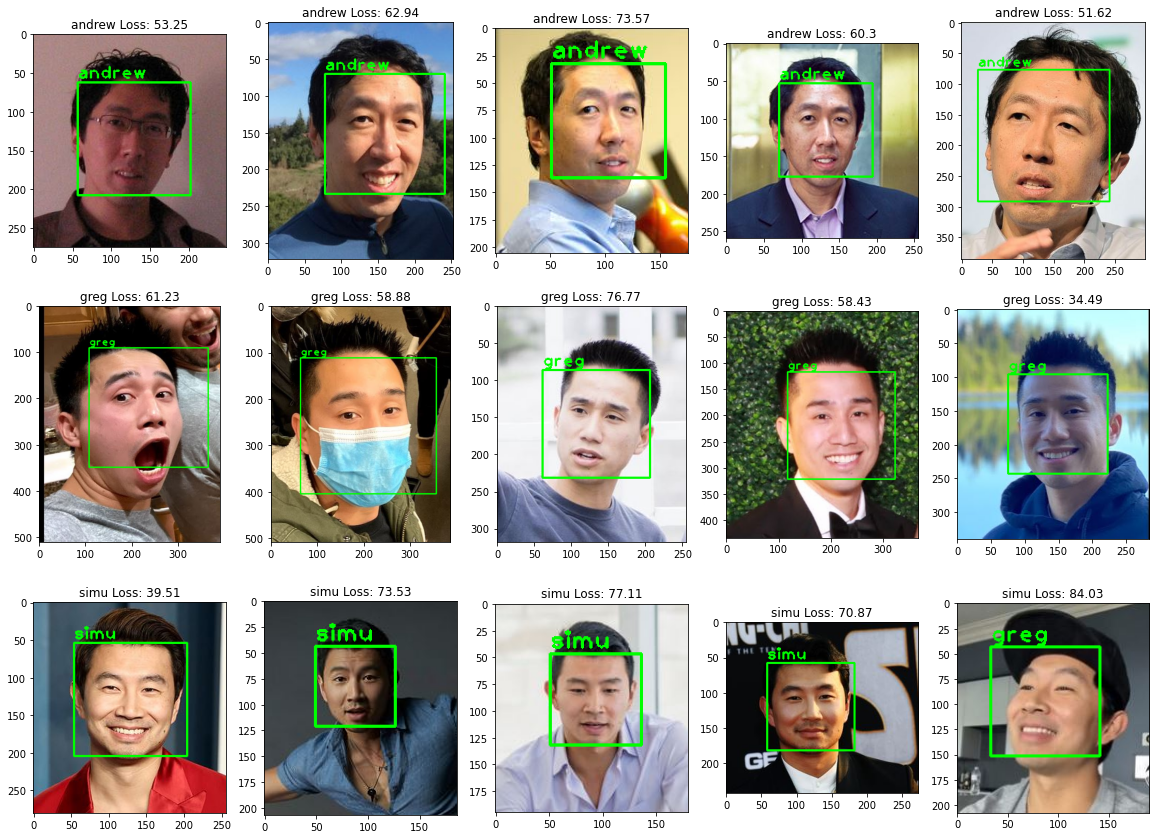

In [10]:
# Then test it on different data.
test_path = 'test'
images, truths, losses = test(test_path)

fig = plt.figure(figsize=(20, 20))
columns = 5
rows = 3

# Display all the test images with the ground truth and loss as the title.
for count, (image, truth, loss) in enumerate(zip(images, truths, losses), start=1):
    fig.add_subplot(rows, columns, count)
    #plt.figure()
    plt.title(str(truth) + " Loss: " + str(loss))
    plt.imshow(image)
    
